In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
import hdbscan

import time
from sklearn.cluster import KMeans

In [2]:
#!source /Users/lui/Documents/3_semestr/Project/env_project/env_project_dap/bin/activate

## Identifying clusters in the 100 pc sphere

<span style="font-size:18px;">

* Clustering in the 100 pc sphere is a challenging task.
* The data is un-evenly dense in two respective subspaces. Especially the velocity space is subject to strong non-linear projection effects.
* An originally compact Gaussian point cloud can result in a highly non-convex shape in the velocity space.

Let's see what this might look like in practice.

</span>

In [3]:
# Plotting related stuff
alphas = [0.9, 0.9, 0.3]
colors = ['tab:red', 'tab:blue', 'tab:grey']
zorders = [1, 1, 0]
log = True

In [4]:
# Create 6D Gaussian data
n = 500 #1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50

mu = np.array([-5, 5, 5, 5, -5, 5])
c_xx = c_yy = 20
c_xy = 15
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2)

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2], axis=0)
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_bg = np.where(labels==0)[0]

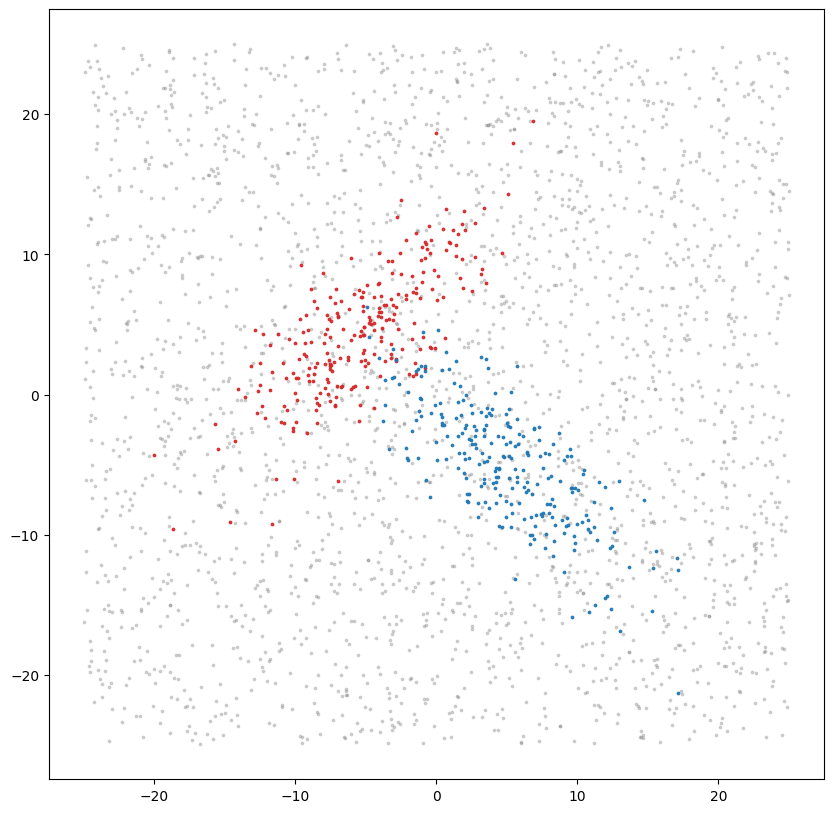

In [5]:
x_col, y_col = 'x', 'y'
# x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
# x_col, y_col = 'pmra', 'pmdec'

fig = plt.figure(figsize=(10, 10))
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_bg], alphas, colors, zorders):
    # if c == 'tab:blue':
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
# plt.xlim(-1000, 1000)
# plt.ylim(-1000, 1000)

# Optimal radial velocity class
VrOpt computes pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.

In [7]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

# Now built the distance matrix for clustering ourselves

In [8]:
# # Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

## Compute the semi-cohesion metric

<span style="font-size:18px;">

Given a semi-metric d(·,·) for $\Omega$, we define the induced semi-cohesion measure as follows:

$$ g(x, y) = \frac{1}{n} \sum_{z_2 \in \Omega} d(z_2, y) + \frac{1}{n} \sum_{z_1 \in \Omega} d(x, z_1) - \frac{1}{n^2}  \sum_{z_2 \in \Omega} \sum_{z_1 \in \Omega} d(z_2, z_1) - d(x, y) $$ 

</span>


In [9]:
# Compute semi-cohesion metric G
G = np.copy(dist_v_opt)
G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G

In [10]:
G

array([[ 15.73151349,   4.66477391,  11.72550683, ...,  -5.79388223,
         -5.18482806,  -3.20028986],
       [  4.66477391,  23.58574923,  16.22574663, ..., -14.39586907,
        -11.64456726,  13.4982426 ],
       [ 11.72550683,  16.22574663,  11.30018159, ...,  -3.0968615 ,
         -7.22651435,  -3.90820031],
       ...,
       [ -5.79388223, -14.39586907,  -3.0968615 , ...,   7.20042951,
          6.45209458,   8.29259888],
       [ -5.18482806, -11.64456726,  -7.22651435, ...,   6.45209458,
          7.23776356,   7.81125011],
       [ -3.20028986,  13.4982426 ,  -3.90820031, ...,   8.29259888,
          7.81125011,   9.44632841]])

## Implement the K-sets+ algorithm

<span style="font-size:18px;">
Implement the K-sets+ algorithm from this paper that uses the above computed semi-cohesion metric, see [here](https://arxiv.org/pdf/1705.04249).

</span>

In [11]:
# Plotting clusters depending on x_col and y_col
def plot_clusters(df, cluster_labels, true_labels, K, x_col, y_col):
    fig, ax = plt.subplots(1, K, figsize=(5*K, 5))
    for l_i in np.unique(cluster_labels):
        if l_i != -1:
            idx_sel = cluster_labels == l_i
            ax[l_i].scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s = 3, alpha = 0.8, zorder = 1, c = true_labels[idx_sel])
            ax[l_i].set_xlabel(x_col)
            ax[l_i].set_ylabel(y_col)
    plt.tight_layout()
    plt.show()


In [12]:
def ksets_plus_optimized(G, K, max_iter=100, method="random"):

    start_time = time.time()
    n = G.shape[0]
    np.random.seed(42)

    # Initialize K disjoint sets
    if method == "random":
        sets = np.random.randint(0, K, size=n)
    elif method == "kmeans":
        kmeans = KMeans(n_clusters=K, random_state=42)
        sets = kmeans.fit_predict(df[['x', 'y', 'z']].values)
    else:
        raise ValueError("Invalid method")
        

    for iteration in range(max_iter):
        
        changes = 0 # Track changes

        
        G_diag = np.diag(G) # Precompute diagonal of G, G[x,x]

        # Compute current cluster sizes |S| - necessary for computing adjusted distances
        cluster_sizes = np.array([np.sum(sets == k) for k in range(K)])

        # Binary matrix to track whether point belongs to specific set
        membership_matrix = np.zeros((n, K))
        for k in range(K):
            membership_matrix[:, k] = (sets == k).astype(int)

        # Compute G[S, S] 
        set_sums = membership_matrix.T @ G @ membership_matrix

        # Compute G[x, S] 
        point_set_sums = G @ membership_matrix

   
        distances = np.zeros((n, K))
        for k in range(K):

            s_size = cluster_sizes[k]

            if s_size == 0:
                continue

            outside_sets = (sets != k)
            inside_sets = (sets == k)

            # For points outside set
            distances[outside_sets, k] = ((s_size / (s_size + 1)) * (G_diag[outside_sets] - 2 * point_set_sums[outside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))

            # For points inside set
            if s_size > 1:
                distances[inside_sets, k] = ((s_size / (s_size - 1)) * (G_diag[inside_sets] - 2 * point_set_sums[inside_sets, k] / s_size + set_sums[k, k] / (s_size ** 2)))
            else:
                distances[inside_sets, k] = -np.inf  

        # Assign points to set with minimum distance
        best_clusters = np.argmin(distances, axis=1)

        # Number of changes
        changes = np.sum(sets != best_clusters)

        sets = best_clusters

        # If no further changes => stop
        if changes == 0:
            break

    execution_time = time.time() - start_time
    print(f'Execution time: {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations: {iteration + 1}')

    return sets


In [13]:
K = 3  
labels_ksets_opt = ksets_plus_optimized(G, K, method = "random")

Execution time: 0 minutes, 0 seconds and 270 ms
Number of iterations: 28


In [14]:
# get number of clusters
unique_clusters = np.unique(labels_ksets_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

3


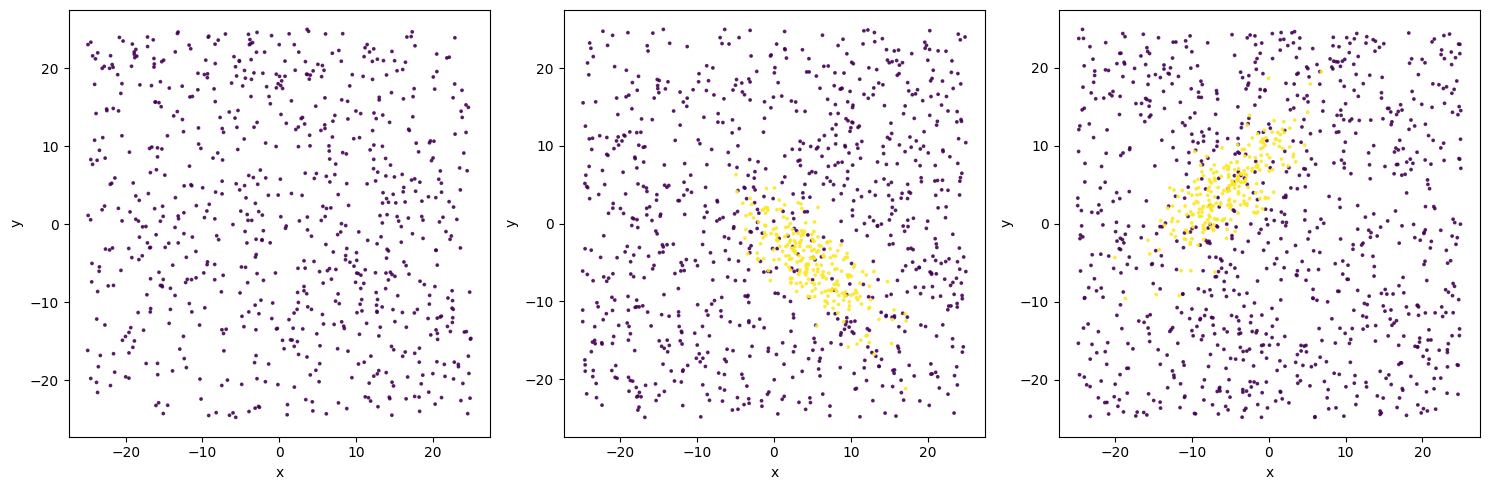

In [15]:
x_col, y_col = 'x', 'y'
plot_clusters(df, labels_ksets_opt, labels, K, x_col, y_col)

## Implement the Softmax Clustering Algorithm

from this paper https://arxiv.org/abs/1708.00316

In [16]:
# get clusters from probability
def get_clusters(p_i):

    cluster_labels = np.argmax(p_i, axis=1)
    _, relabeled_clusters = np.unique(cluster_labels, return_inverse=True)
    
    return relabeled_clusters


In [17]:
def softmax_clustering_optimized_iphd(Gamma, K, theta=0.001, epsilon=0.0001, max_iter=250, initial_partition=None):

    start_time = time.time()

    # Set g[i,i] = 0 for all i
    np.fill_diagonal(Gamma, 0)
    n = Gamma.shape[0]

    np.random.seed(42)

    # Use the initial partition if provided, otherwise initialize randomly
    if initial_partition is not None:
        p_i = initial_partition
    else:
        p_i = np.random.dirichlet(np.ones(K), size=n)

    z = np.zeros((n, K))  # for covariance

    for iteration in range(max_iter):
        # Compute covaraince (z)for all points and clusters
        z = Gamma @ p_i 

        p_t = np.exp(theta * z) * p_i  # Softmax function
        p_i = p_t / np.sum(p_t, axis=1, keepdims=True)  # Update probability uisng softmax function and normalize it (it must sum to 1)

        theta += epsilon

         # If pi changes insignificantly, stop
        if iteration > 0 and np.allclose(p_i, prev_pi, atol=1e-6):
            break

        prev_pi = p_i.copy()
        
    execution_time = time.time() - start_time
    print(f'Execution time (softmax): {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations (softmax): {iteration + 1}')

    return p_i, z

In [18]:
K = 6
p_i_opt, z_opt = softmax_clustering_optimized_iphd(G, K)

#print("Probability partition of data points (pi):")
#print(p_i_opt)
#print("Embedding of data points(z):")
#print(z_opt)


Execution time (softmax): 0 minutes, 1 seconds and 672 ms
Number of iterations (softmax): 250


In [19]:
# get cluster labels and number of clusters
labels_softmax_opt= get_clusters(p_i_opt) 
unique_clusters = np.unique(labels_softmax_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

4


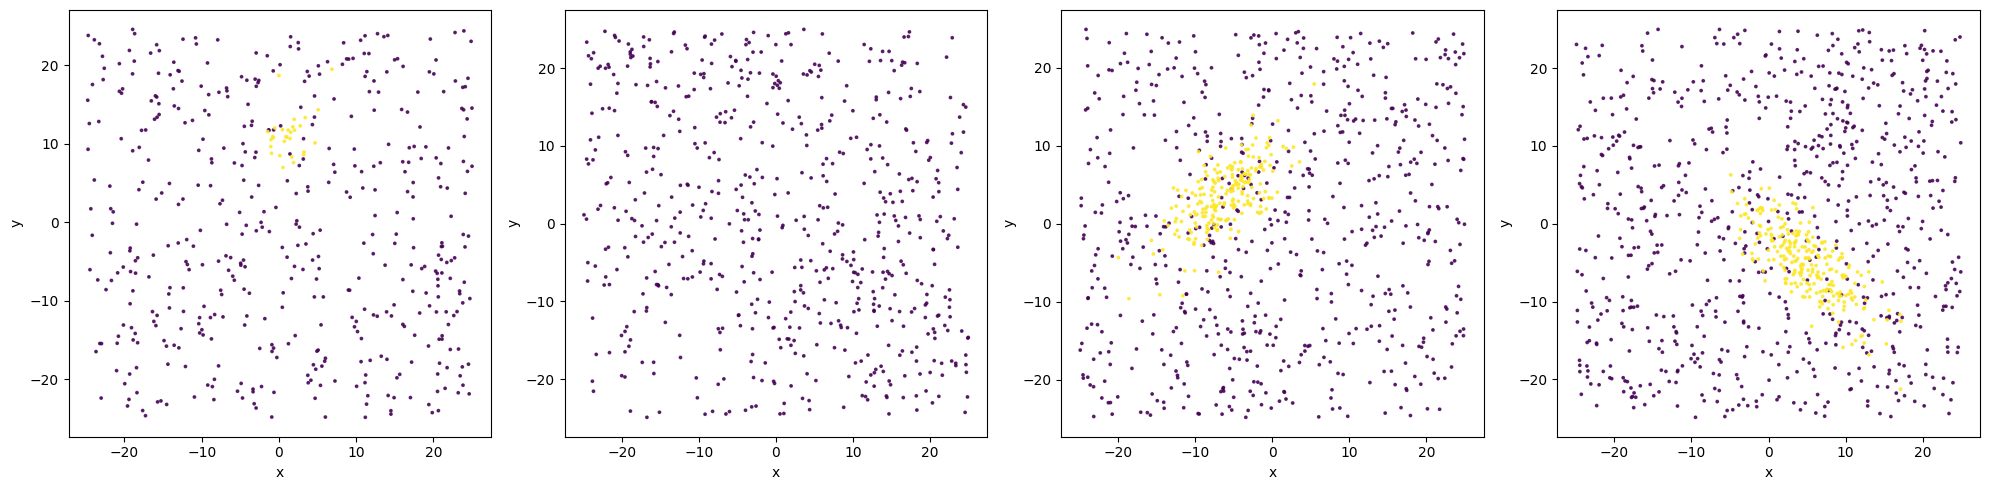

In [20]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_softmax_opt, labels, num_clusters, x_col, y_col)

## The Hierarchical Agglomerative Algorithm
https://dl.acm.org/doi/10.1109/TNET.2017.2762403

In [21]:
# equation (9) 
def compute_transition_probability(G, p_lambda = 1):

    n = G.shape[0]
    # Row sum for each node i 
    degrees = G.sum(axis=1) + 1e-10  # to avoid division by zero
    transition_prob = (1 - p_lambda) / n + p_lambda * (G / degrees[:, None])

    # Needed to avoid overflow and underflow
    transition_prob = np.maximum(np.minimum(transition_prob, 1 - 1e-10), 1e-10)
    return transition_prob

# equation (10)
def compute_steady_probability(G, p_lambda= 1, tol=1e-6, max_iter=100):
    
    n = G.shape[0]
    pi = np.ones(n) / n  
    transition_prob= compute_transition_probability(G, p_lambda)

    for _ in range(max_iter):
        pi_new = (1 - p_lambda) / n + p_lambda * transition_prob.T @ pi

        # Normalize to avoid large values in pi_new
        pi_new /= np.sum(pi_new)
        if np.linalg.norm(pi_new - pi, 1) < tol:
            break
        pi = pi_new

    return pi

def compute_correlation_matrix(G, p_lambda=1):

    # equations (11), (27)
    pi_v = compute_steady_probability(G, p_lambda)
    
    transition_prob = compute_transition_probability(G, p_lambda)
    
    # equation (11)
    p_vw = (pi_v.reshape(-1, 1) * np.ones(G.shape[0])) * transition_prob

    p_V = p_vw.sum(axis=1)
    p_W = p_vw.sum(axis=0)

    # Set threshold to avoid overflow and nans
    p_vw = np.maximum(np.minimum(p_vw, 1e10), 1e-10)
    p_V = np.maximum(np.minimum(p_V, 1e10), 1e-10)
    p_W = np.maximum(np.minimum(p_W, 1e10), 1e-10)
    
    # equation (27)
    q = 0.5 * (p_vw - (p_V.reshape(-1, 1) * p_W) + p_vw.T - (p_W.reshape(-1, 1) * p_V))
    return q


In [22]:
# different sampling method
'''
# equation (4) - uniform edge sampling
def compute_uniform_edge_probability(G):
    m = np.sum(G)  
    p_vw = G / m   # p(v, w) = a_vw / m
    return p_vw

def compute_correlation_matrix(G):

    p_vw = compute_uniform_edge_probability(G)

    p_V = p_vw.sum(axis=1)  
    p_W = p_vw.sum(axis=0)  

    # Set threshold to avoid overflow and nans
    p_vw = np.maximum(np.minimum(p_vw, 1e10), 1e-10)
    p_V = np.maximum(np.minimum(p_V, 1e10), 1e-10)
    p_W = np.maximum(np.minimum(p_W, 1e10), 1e-10)
    

    # equation (27)
    q = 0.5 * (p_vw - (p_V.reshape(-1, 1) * p_W) + p_vw.T - (p_W.reshape(-1, 1) * p_V))

    
    return q  

'''


'\n# equation (4) - uniform edge sampling\ndef compute_uniform_edge_probability(G):\n    m = np.sum(G)  \n    p_vw = G / m   # p(v, w) = a_vw / m\n    return p_vw\n\ndef compute_correlation_matrix(G):\n\n    p_vw = compute_uniform_edge_probability(G)\n\n    p_V = p_vw.sum(axis=1)  \n    p_W = p_vw.sum(axis=0)  \n\n    # Set threshold to avoid overflow and nans\n    p_vw = np.maximum(np.minimum(p_vw, 1e10), 1e-10)\n    p_V = np.maximum(np.minimum(p_V, 1e10), 1e-10)\n    p_W = np.maximum(np.minimum(p_W, 1e10), 1e-10)\n    \n\n    # equation (27)\n    q = 0.5 * (p_vw - (p_V.reshape(-1, 1) * p_W) + p_vw.T - (p_W.reshape(-1, 1) * p_V))\n\n    \n    return q  \n\n'

In [23]:
def hierarchical_agglomerative_clustering(G, initial_partition, min_correlation_threshold=0):
   
    # equation (27)
    q = compute_correlation_matrix(G)
    clusters = [set(cluster) for cluster in initial_partition]
    
    while True:
        n = len(clusters)
        cluster_corr = np.zeros((n, n))

        # Calculate q(Si, Sj, equation (28)
        for i in range(n):
            for j in range(i + 1, n):
                cluster_corr[i, j] = np.sum(q[np.ix_(list(clusters[i]), list(clusters[j]))])
                #because q(Si, Sj) = q(Sj, Si)
                cluster_corr[j, i] = cluster_corr[i, j]

        # Look for pair with maximum positive correlation
        max_value = -np.inf  
        i, j = -1, -1        
        for row in range(cluster_corr.shape[0]):
            for col in range(row + 1, cluster_corr.shape[1]):  
                if not np.isnan(cluster_corr[row, col]) and cluster_corr[row, col] > max_value:
                    max_value = cluster_corr[row, col]
                    i, j = row, col
        
        # Use some min_correlation_threshold instead of 0, attempt to stop merging into one cluster
        if cluster_corr[i, j] <= min_correlation_threshold:
            break

        # Merge Si and Sj
        new_cluster = clusters[i].union(clusters[j])
        clusters = [clusters[k] for k in range(n) if k != i and k != j]
        clusters.append(new_cluster)

        # Update correlations for new merged cluster
        new_n = len(clusters)
        new_cluster_corr = np.zeros((new_n, new_n))
        
        # Copy over existing correlations
        for k in range(new_n - 1):
            for l in range(new_n - 1):
                new_cluster_corr[k, l] = cluster_corr[k, l]
        
        # equation (30)
        new_idx = new_n - 1
        new_cluster_corr[new_idx, new_idx] = (
            cluster_corr[i, i] + 2 * cluster_corr[i, j] + cluster_corr[j, j]
        )

        # equation (31)
        for l in range(new_n - 1):
            new_cluster_corr[new_idx, l] = cluster_corr[i, l] + cluster_corr[j, l]
            new_cluster_corr[l, new_idx] = new_cluster_corr[new_idx, l]
        
        cluster_corr = new_cluster_corr
    
    return clusters


## The Iterative Partitional-Hierarchical (iPHD) Algorithm

In [24]:
# To be able to compare labels for softmax_clustering and hierarchical_agglomerative_clustering
def normalize_labels(labels):
    _, normalized_labels = np.unique(labels, return_inverse=True)
    return normalized_labels

def iphd_algorithm(Gamma, initial_K, theta=0.001, epsilon=0.0001, max_iter=500, nmi_threshold=0.99):
    
    start_time = time.time()
    n = Gamma.shape[0]
    K = initial_K  
    iteration = 0

    p_i, z = softmax_clustering_optimized_iphd(Gamma, K, theta, epsilon, max_iter)
    
    while True:
        iteration += 1

        prev_labels = normalize_labels(np.argmax(p_i, axis=1))

        softmax_partition = [np.where(prev_labels == k)[0] for k in np.unique(prev_labels)]

        print("Number of clusters after using softmax:", np.unique(prev_labels))

        new_partition = hierarchical_agglomerative_clustering(Gamma, softmax_partition)


        # Get labels from partition format
        new_labels = np.zeros(n, dtype=int)
        for idx, cluster in enumerate(new_partition):
            new_labels[list(cluster)] = idx
        new_labels = normalize_labels(new_labels)

        nmi_score = normalized_mutual_info_score(prev_labels, new_labels)
        print(f"NMI score between iterations: {nmi_score:.4f}")

        if nmi_score >= nmi_threshold:
            break

        prev_labels = new_labels

        # Get partition for input to  softmax using output partition form  hierarchical_agglomerative_clustering
        initial_p_i = np.zeros((n, K))
        for k, cluster in enumerate(new_partition):
            initial_p_i[list(cluster), k] = 1 
        
        p_i, z = softmax_clustering_optimized_iphd(Gamma, K, theta, epsilon, max_iter, initial_partition=initial_p_i)

    # Calculate corresponding embedding for final partition
    embeddings = np.zeros((n, len(new_partition)))
    for k, cluster in enumerate(new_partition):
        for i in cluster:
            embeddings[i, k] = np.sum([Gamma[i, j] for j in cluster])

    execution_time = time.time() - start_time
    print(f'Execution time (iphd): {int(execution_time // 60)} minutes, {int(execution_time % 60)} seconds and {int((execution_time % 1) * 1000)} ms')
    print(f'Number of iterations (iphd): {iteration}')

    return new_partition, embeddings


In [25]:
initial_K = 9
final_partitions, embeddings = iphd_algorithm(G, initial_K)

#print("Final partitions:", final_partitions)
print("Embeddings shape:", embeddings.shape)

Execution time (softmax): 0 minutes, 1 seconds and 51 ms
Number of iterations (softmax): 192
Number of clusters after using softmax: [0 1 2]
NMI score between iterations: 1.0000
Execution time (iphd): 0 minutes, 1 seconds and 937 ms
Number of iterations (iphd): 1
Embeddings shape: (3000, 3)


In [26]:
# Convert into label array 
def get_iphd_labels(final_clusters, n_samples):
    labels = -np.ones(n_samples, dtype=int)  
    for cluster_id, cluster in enumerate(final_clusters):
        labels[list(cluster)] = cluster_id
    return labels

In [27]:
labels_iphd = get_iphd_labels(final_partitions, len(df))
num_clusters = len(final_partitions)
print(labels_iphd)
print(num_clusters)

[2 2 2 ... 0 0 0]
3


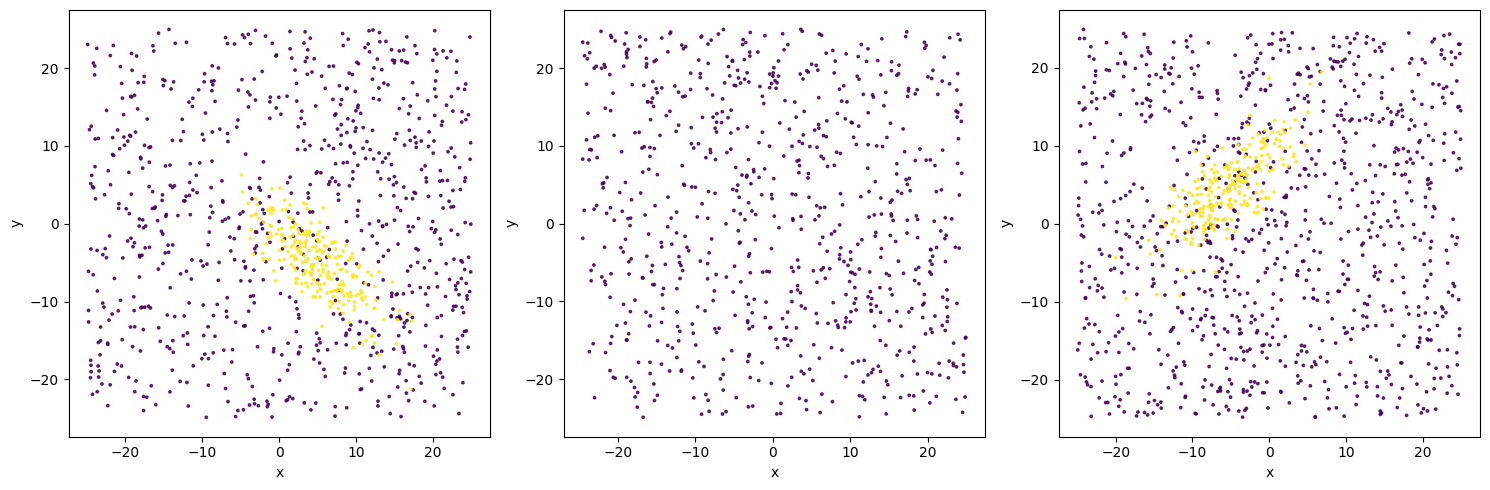

In [28]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, labels_iphd, labels, num_clusters, x_col, y_col)

# Clustering with KD tree, Softmax algorithm, and Hierarchical agglomerative algorithm

In [29]:
# Safe true labels from dataset
original_label = labels

In [35]:
from scipy.spatial import KDTree

leaf_size = 300 # how should it be defined?
points = df[['x', 'y', 'z']].values
kd_tree = KDTree(points, leafsize=leaf_size)

# To track which points belong to each node
node_indices = [] # To be sure that each point is in only one node
point_in_node = {}  

# Function to process each node in KD-tree
def extract_node(kd_node, point_indices):
 
    if isinstance(kd_node, KDTree.leafnode):
        # Get points from leaves
        unique_indices = []

        for idx in point_indices:
            if idx not in point_in_node:
                unique_indices.append(idx)

        node_indices.append(unique_indices)
        
        # Update number of points in node
        for idx in unique_indices:
            point_in_node[idx] = len(node_indices) - 1
    else:
        # Get points from internal node, split points
        split_dim = kd_node.split_dim
        split_val = kd_node.split

        left_indices = []
        right_indices = []

        for i in point_indices:
            if points[i, split_dim] <= split_val:
                left_indices.append(i) 
            else:
                right_indices.append(i)
        
        # Process nodes (left and right)
        extract_node(kd_node.less, left_indices)
        extract_node(kd_node.greater, right_indices)
        
        # Update number of points in node
        unique_indices = []
        for idx in point_indices:
            if idx not in point_in_node:
                unique_indices.append(idx)

        node_indices.append(unique_indices)

        for idx in unique_indices:
            point_in_node[idx] = len(node_indices) - 1

# Processing all nodes
extract_node(kd_tree.tree, list(range(len(points))))

# Check if coorect number of points
unique_assigned_points = set(point_in_node.keys())
print(f"Total number of points in tree: {len(unique_assigned_points)}")

# Calculate global semi-cohesian metric G 
def compute_g_matrix(dist_matrix):

    G = np.copy(dist_matrix)
    G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G
    return G

# Pairwise distance matrix for entire dataset
dist_matrix = dist_v_opt
G = compute_g_matrix(dist_matrix)

# Run softmax clustering algorithm in each node
cluster_results = []
for i, indices in enumerate(node_indices):
    subset_G = G[np.ix_(indices, indices)] # Take onlny G for poins in node
    p_i, z = softmax_clustering_optimized_iphd(subset_G, K)
    cluster_labels_node = get_clusters(p_i)
    
    if len(cluster_labels_node) != len(indices):
        print(f"Wrong number of points after clustering in node:{i + 1}")
    
    clusters_in_node = np.unique(cluster_labels_node)
    num_clusters = len(clusters_in_node)
    
    # Info about node after clustering
    print(f"Node {i + 1}:")
    print(f" - Number of clusters: {num_clusters}")
    print(f" - Number of points: {len(indices)}")
    
    cluster_results.append((cluster_labels_node, indices))

total_softmax_clusters = 0

for labels, _ in cluster_results:
    unique_labels = np.unique(labels)
    total_softmax_clusters += len(unique_labels)

print(f"Total number of clusters after softmax clustering in all nodes: {total_softmax_clusters}")

# Correlation measure q for two sets
def compute_q(S1, S2, G):
    total_sum = 0
    for x in S1:
        for y in S2:
         total_sum += G[x, y]
    return total_sum
 
# Collect all points that belong to cluster.
clusters = []
for labels, indices in cluster_results:
    for label in np.unique(labels):
        cluster = {index for index, lbl in zip(indices, labels) if lbl == label}
        clusters.append(cluster)

# Hierarchical agglomerative algorithm - merging
while len(clusters) > 1:
    # Initialize q matrix
    num_clusters = len(clusters)
    q_matrix = np.full((num_clusters, num_clusters), -np.inf)
    
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            if clusters[i] and clusters[j]:  # clusters cannot be empty
                q_matrix[i, j] = compute_q(clusters[i], clusters[j], G)
                q_matrix[j, i] = q_matrix[i, j]

    # Find pair idicies with maximum positive q value
    max_index = np.argmax(q_matrix)

    n_rows, n_cols = q_matrix.shape
    i = max_index // n_cols 
    j = max_index % n_cols
    if q_matrix[i, j] <= 0:
        print("No positive q values, stop merging")
        break

    # Merge clusters i and j
    new_cluster = clusters[i].union(clusters[j])  # Use union to handle any overlaps
    clusters.append(new_cluster)

    # Just for tests
    unique_total_points = len(set().union(*clusters))
    print(f"Total unique points after merging clusters {i} and {j}: {unique_total_points}")

    # Deactivate merged clusters
    q_matrix[i, :] = -np.inf
    q_matrix[:, i] = -np.inf
    q_matrix[j, :] = -np.inf
    q_matrix[:, j] = -np.inf

    # Remove merged clusters from list
    clusters[i] = set()
    clusters[j] = set()

# Check number of points in final clusterig
final_clusters = [cluster for cluster in clusters if len(cluster) > 0]
total_points_final = len(set().union(*final_clusters))
print(f"Original number of points: {len(df)}")
print(f"Total number of unique points in all final clusters: {total_points_final}")

Total number of points in tree: 3000
Execution time (softmax): 0 minutes, 0 seconds and 12 ms
Number of iterations (softmax): 250
Node 1:
 - Number of clusters: 4
 - Number of points: 188
Execution time (softmax): 0 minutes, 0 seconds and 11 ms
Number of iterations (softmax): 250
Node 2:
 - Number of clusters: 3
 - Number of points: 189
Execution time (softmax): 0 minutes, 0 seconds and 0 ms
Number of iterations (softmax): 2
Node 3:
 - Number of clusters: 0
 - Number of points: 0
Execution time (softmax): 0 minutes, 0 seconds and 11 ms
Number of iterations (softmax): 250
Node 4:
 - Number of clusters: 3
 - Number of points: 188
Execution time (softmax): 0 minutes, 0 seconds and 9 ms
Number of iterations (softmax): 192
Node 5:
 - Number of clusters: 3
 - Number of points: 186
Execution time (softmax): 0 minutes, 0 seconds and 0 ms
Number of iterations (softmax): 2
Node 6:
 - Number of clusters: 0
 - Number of points: 0
Execution time (softmax): 0 minutes, 0 seconds and 0 ms
Number of it

In [36]:
total_points = 0
for cluster in final_clusters:
    total_points += len(cluster)
original_point_count = len(df)
print(f"Original number of points: {original_point_count}")
print(f"Total number of points in all clusters: {total_points}")

Original number of points: 3000
Total number of points in all clusters: 3000


In [37]:
cluster_labels = np.zeros(len(df), dtype=int) - 1  # for unassigned points
for i, cluster in enumerate(final_clusters):
    for index in cluster:
        cluster_labels[index] = i

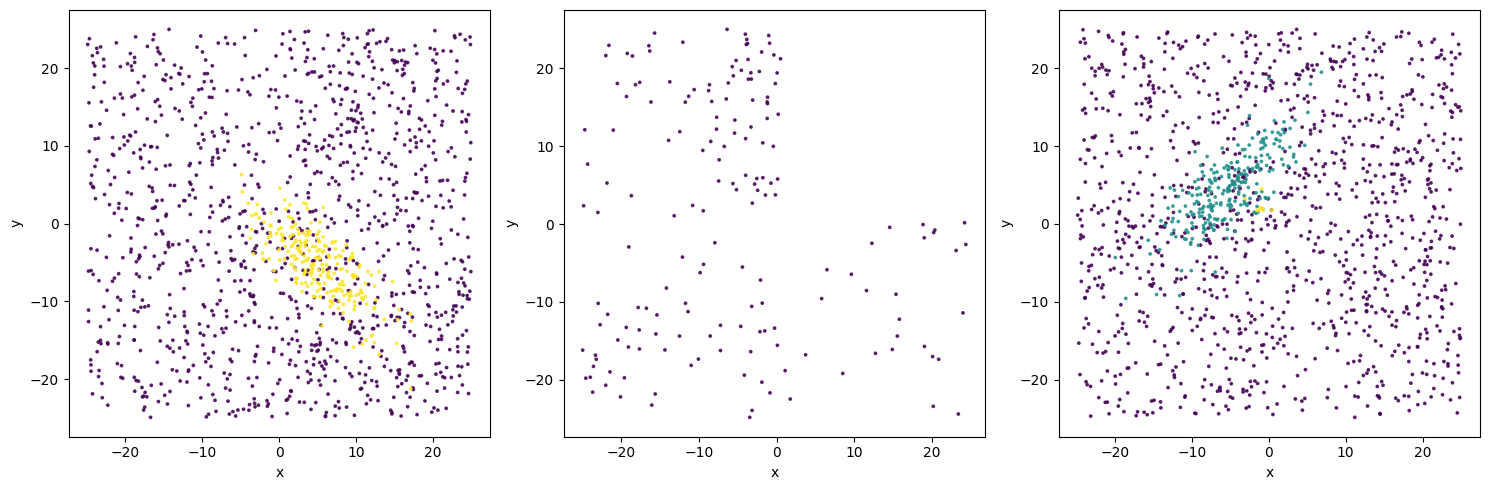

In [38]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
plot_clusters(df, cluster_labels, original_label, len(final_clusters), x_col, y_col)